# AH2179 Applied Artificial Intelligence in Transportation Group 5 Project
### By Fabian Fermazin, William Öman, Itsuki Shindo

In [1]:
import pandas as pd
from datetime import datetime

In [89]:
df = pd.read_csv('../Dataset-PT_seasons.csv')
Stockholmtemp2022 = pd.read_csv('../Stockholmtemp2022.csv', sep=';')

In [90]:
# Change the date format of Stockholmtemp2022 to match the df
def change_date_format(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime("%Y%m%d")
Stockholmtemp2022["date"] = Stockholmtemp2022["date"].apply(change_date_format)

# Change the name of the date column to match the df
Stockholmtemp2022["Calendar_date"] = 0
Stockholmtemp2022["Calendar_date"] = Stockholmtemp2022["date"]
Stockholmtemp2022.drop(columns=["date"])

,temp,Calendar_date
0,-1.4,20220101
1,1.9,20220102
2,3.6,20220103
3,0.6,20220104
4,-2.2,20220105
...,...,...
176,23.1,20220626
177,24.1,20220627
178,24.1,20220628
179,19.6,20220629


In [95]:
# Merge df and Stockholmtemp2022
Stockholmtemp2022["Calendar_date"] = Stockholmtemp2022["Calendar_date"].astype(int)
df = pd.merge(df, Stockholmtemp2022, on='Calendar_date')
df.drop(columns=['date'])

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,Season,date_x,temp_x,date_y,temp_y,temp
0,20220108,4,41344,1,151,0,0,120,100,100,...,1,0,0,1,Winter,20220108,-0.5,20220108,-0.5,-0.5
1,20220108,4,41344,2,185,24,171,45,151,100,...,1,0,0,1,Winter,20220108,-0.5,20220108,-0.5,-0.5
2,20220108,4,41344,3,186,0,55,41,185,100,...,1,0,0,1,Winter,20220108,-0.5,20220108,-0.5,-0.5
3,20220108,4,41344,4,202,12,42,94,186,100,...,1,0,0,1,Winter,20220108,-0.5,20220108,-0.5,-0.5
4,20220108,4,41344,5,242,21,98,86,202,100,...,1,0,0,1,Winter,20220108,-0.5,20220108,-0.5,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,74,44,341,12,...,0,0,0,1,Summer,20220630,22.4,20220630,22.4,22.4
545099,20220630,4,41362,24,330,15,34,92,344,12,...,0,0,0,1,Summer,20220630,22.4,20220630,22.4,22.4
545100,20220630,4,41362,25,339,17,63,43,330,12,...,0,0,0,1,Summer,20220630,22.4,20220630,22.4,22.4
545101,20220630,4,41362,26,331,0,35,58,339,12,...,0,0,0,1,Summer,20220630,22.4,20220630,22.4,22.4


In [21]:
# Load in data after Itsuki and William Cleaning
df = pd.read_csv('../data/clean_dataPT2.csv')

In [22]:
#Check if the loading is correct
df.head()

,Unnamed: 0,Calendar_date,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Snow,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,Season,date,temp,trip_id
0,0,2022-01-08,41344,1,151,0,0,120,100,100,...,0,0,1,0,0,1,Winter,20220108,-0.5,1
1,1,2022-01-08,41344,2,185,24,171,45,151,100,...,0,0,1,0,0,1,Winter,20220108,-0.5,1
2,2,2022-01-08,41344,3,186,0,55,41,185,100,...,0,0,1,0,0,1,Winter,20220108,-0.5,1
3,3,2022-01-08,41344,4,202,12,42,94,186,100,...,0,0,1,0,0,1,Winter,20220108,-0.5,1
4,4,2022-01-08,41344,5,242,21,98,86,202,100,...,0,0,1,0,0,1,Winter,20220108,-0.5,1


In [23]:
# Eliminate negative arrival delays
import numpy as np
df['arrival_delay'] = df['arrival_delay'].map(np.abs)

In [27]:
# Check if any negative arrival left
df[df['arrival_delay'] < 0]['bus_id'].count()

0

In [30]:
df.to_csv('../data/clean_dataPT2.csv')

In [20]:
# Finding a unique key value of the bus data
df.groupby(['Calendar_date', 'bus_id', 'stop_sequence'])['dwell_time'].count().sort_values(ascending=False)

Calendar_date  bus_id  stop_sequence
2022-02-13     41348   20               11
2022-05-15     41344   4                11
                       16               11
                       15               11
                       14               11
                                        ..
2022-06-07     44076   20                1
                       19                1
                       18                1
                       17                1
2022-06-30     45722   27                1
Name: dwell_time, Length: 111024, dtype: int64

In [ ]:
# Dropping route_id , temperature, factor(temperature)Cold, factor(temperature)Extra_Cold, factor 

In [54]:
df_test = df.groupby(['trip_id'])[['arrival_delay', 'dwell_time', 'traffic_condition', 'recurrent_delay', 'origin_delay', 'previous_bus_delay', 'factor(day_of_week)weekday', 'factor(time_of_day)Off-peak', 'temp']].mean()

In [55]:
df_test

,arrival_delay,dwell_time,traffic_condition,recurrent_delay,origin_delay,previous_bus_delay,factor(day_of_week)weekday,factor(time_of_day)Off-peak,temp
trip_id,,,,,,,,,
1,340.000000,14.037037,65.234568,60.203704,100.0,188.296296,0.0,1.0,-0.5
2,149.222222,9.000000,69.061728,62.318519,17.0,340.000000,0.0,1.0,-0.5
3,86.111111,19.259259,69.691358,64.018519,10.0,149.222222,0.0,1.0,-0.5
4,27.037037,13.888889,67.049383,63.137566,12.0,85.518519,0.0,1.0,-0.5
5,221.296296,18.962963,63.617284,59.898148,3.0,-0.296296,0.0,1.0,-0.5
...,...,...,...,...,...,...,...,...,...
20185,112.555556,25.592593,72.938272,65.666099,17.0,185.074074,1.0,1.0,22.4
20186,151.851852,34.629630,72.407407,65.674356,20.0,107.296296,1.0,1.0,22.4
20187,179.592593,26.333333,67.456790,65.662792,21.0,151.851852,1.0,1.0,22.4


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [56]:
scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(df_test)
Scaled_data=scaling.transform(df_test)
 
# Set the n_components=3
principal=PCA(n_components=2)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)
 
# Check the dimensions of data after PCA
print(x.shape)

(20188, 2)


c:\Users\fabia\anaconda3\envs\aitransport\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\fabia\anaconda3\envs\aitransport\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\fabia\anaconda3\envs\aitransport\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\fabia\anaconda3\envs\aitransport\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu

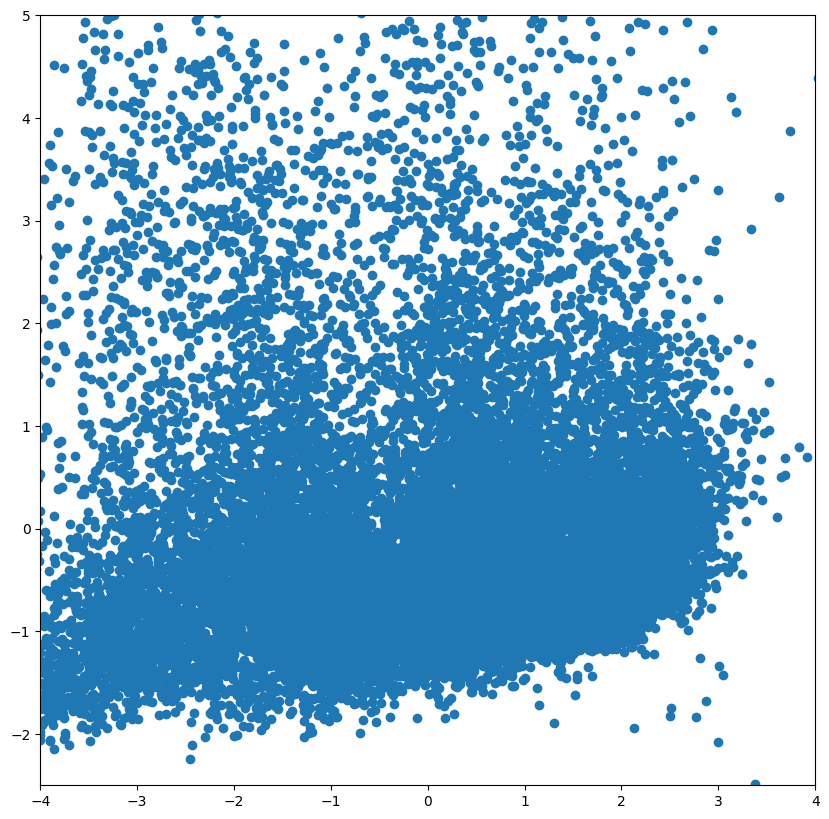

In [61]:
plt.figure(figsize=(10,10))
plt.xlim(-4,4)
plt.ylim(-2.5,5)
plt.scatter(x[:,0],x[:,1])

In [62]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

In [68]:
x

array([[-4.25598008, -0.14444125],
       [-3.9560659 , -0.94691599],
       [-2.92778019, -1.26238817],
       ...,
       [-1.59164397, -0.01051854],
       [-1.73883626, -0.35568009],
       [-1.50179583,  0.05649703]])

In [69]:
# BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
clusters = KMeans(n_clusters=5, random_state=0, n_init="auto")# check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
clusters.fit(x)
#clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
#clusters = DBSCAN(eps=500, min_samples = 2).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

#if clusters is not None:
# cluster_labels = clusters.labels_

#cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py


print(cluster_labels)

AttributeError: 'NoneType' object has no attribute 'split'